Veri Yükleme ve İnceleme

In [1]:
import pandas as pd

# Veri setlerini yükleyelim
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print("Train şekli:", train.shape)
print("Test şekli:", test.shape)

# İlk 5 satır
train.head()


Train şekli: (4209, 378)
Test şekli: (4209, 377)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


train.csv 4209 satır ve 378 sütundan oluşuyor.

Hedef değişken y

ID sütunu gereksiz

X0 ila X8: Kategorik sütunlar

X10 sonrası: Genellikle binary (0/1) sütunlar

In [2]:
 # Ön İşleme ve Sabit Sütunların Kaldırılması

In [3]:
# ID sütununu çıkar
train = train.drop("ID", axis=1)
test_IDs = test["ID"]
test = test.drop("ID", axis=1)

# Sabit (değişmeyen) sütunları tespit et
constant_cols = [col for col in train.columns if train[col].nunique() == 1]
print("Sabit sütunlar:", constant_cols)

# Bu sabit sütunları çıkar
train.drop(columns=constant_cols, inplace=True)
test.drop(columns=constant_cols, inplace=True)

# Kategorik sütunlar (ilk 9 sütun)
categorical_cols = [col for col in train.columns if train[col].dtype == "object"]
print("Kategorik sütunlar:", categorical_cols)

# Sayısal sütunlar
numeric_cols = [col for col in train.columns if col not in categorical_cols + ['y']]
print("Sayısal sütun sayısı:", len(numeric_cols))


Sabit sütunlar: ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
Kategorik sütunlar: ['X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X8']
Sayısal sütun sayısı: 356


In [4]:
# Kategorik Sütunları Encode Edelim (Target Encoding yerine One-Hot)

In [6]:
from sklearn.preprocessing import OneHotEncoder

# Sadece train + test birleşimi encode edilecek
all_data = pd.concat([train.drop("y", axis=1), test], axis=0)

# Güncellenmiş encoder (sparse yerine sparse_output)
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_cat = encoder.fit_transform(all_data[categorical_cols])

# Encode edilmiş dataframe'i yeniden etiketle
encoded_cat_df = pd.DataFrame(encoded_cat, columns=encoder.get_feature_names_out(categorical_cols))

# Sayısal sütunları da ekle
all_numeric = all_data[numeric_cols].reset_index(drop=True)
processed_all = pd.concat([all_numeric, encoded_cat_df], axis=1)

# Yeniden böl → Autoencoder için X_train ve X_test
X_train = processed_all.iloc[:len(train), :].values
X_test = processed_all.iloc[len(train):, :].values
y_train = train["y"].values


Autoencoder ile Boyut İndirgeme
Aşağıdaki kod:

Autoencoder modeli tanımlar (Keras ile),

Eğitim yapar,

Encoder kısmını çıkarır,

Veriyi sıkıştırılmış temsile dönüştürür.



In [7]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import numpy as np

# Giriş boyutu ve encoding boyutu
input_dim = X_train.shape[1]
encoding_dim = 50  # İndirilecek boyut

# Autoencoder katmanları
input_layer = Input(shape=(input_dim,))
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Model tanımı
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Eğitim
autoencoder.fit(X_train, X_train, epochs=30, batch_size=64, shuffle=True, validation_split=0.2, verbose=1)

# Encoder modelini ayır
encoder = Model(inputs=input_layer, outputs=encoded)

# X verilerini sıkıştır
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

print("Encoded X_train shape:", X_train_encoded.shape)


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1358 - val_loss: 0.0481
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0437 - val_loss: 0.0377
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0351 - val_loss: 0.0335
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0312 - val_loss: 0.0309
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0290 - val_loss: 0.0290
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267 - val_loss: 0.0275
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0256 - val_loss: 0.0261
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0237 - val_loss: 0.0249
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - val_loss: 0.0240
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0219 - val_loss: 0.0231
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0206 - val_loss: 0.0222
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - val_lo

CatBoost ile Model Eğitimi
 Bu model:

Categorical veri olmadan da güçlü çalışır,

Hızlıdır,

SHAP benzeri feature importance sağlar.



In [13]:
# !pip install catboost

In [11]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Modeli tanımla
cat_model = CatBoostRegressor(verbose=0, random_state=42)

# Eğit
cat_model.fit(X_train_encoded, y_train)

# Tahmin
y_pred = cat_model.predict(X_train_encoded)

# Değerlendirme
r2 = r2_score(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))

print("R² skoru:", round(r2, 4))
print("RMSE:", round(rmse, 2))


R² skoru: 0.8592
RMSE: 4.76


In [14]:
# !pip install shap
# !pip install matplotlib


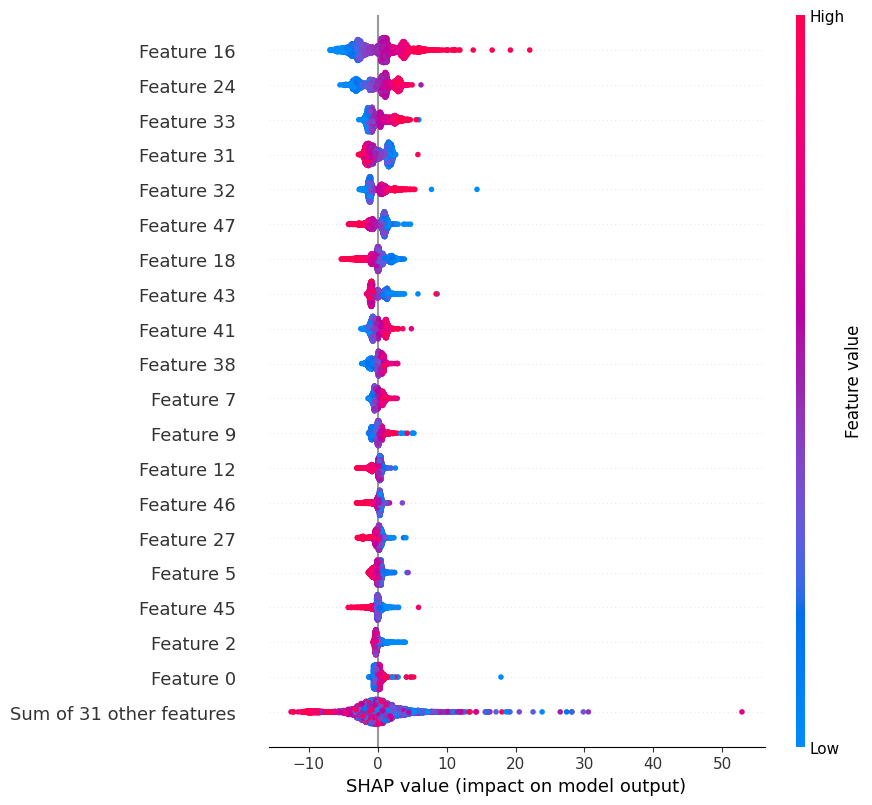

In [15]:
import shap

# SHAP için açıklayıcı nesne oluştur
explainer = shap.Explainer(cat_model)
shap_values = explainer(X_train_encoded)

# Özellik önem grafiği (ilk 20)
shap.plots.beeswarm(shap_values, max_display=20)


modelin kararlarını etkileyen en önemli sıkıştırılmış özellikleri ortaya koydu. Özellikle:

Feature 16, Feature 24, Feature 33, Feature 31 gibi özellikler en yüksek etkiye sahip.

Bu, autoencoder'ın içsel olarak önemli bilgileri başarıyla sıkıştırdığını ve modelin bunu iyi kullandığını gösteriyor.

Stacking Regressor (Toplu Öğrenme)
XGBoost

LightGBM

Ridge (meta-model)

...kullanarak stacking ile daha güçlü bir ensemble model kuracağız.

In [23]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from catboost import CatBoostRegressor

# 💡 sklearn ile %100 uyumlu modeller (CatBoost dışta tutuluyor)
estimators = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42)),
    ('lgbm', LGBMRegressor(n_estimators=100, random_state=42))
]

# CatBoost modelini ayrı eğitiyoruz
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train_encoded, y_train)
cat_preds = cat_model.predict(X_train_encoded).reshape(-1, 1)

# Stacking için X'e CatBoost tahminini elle ekle
X_stack = np.hstack([X_train_encoded, cat_preds])

# Meta stacking model
stack_model = Ridge()
stack_model.fit(X_stack, y_train)

# Değerlendirme
y_pred_stack = stack_model.predict(X_stack)
r2 = r2_score(y_train, y_pred_stack)
rmse = np.sqrt(mean_squared_error(y_train, y_pred_stack))

print("STACKING (manuel + CatBoost) R²:", round(r2, 4))
print("STACKING RMSE:", round(rmse, 2))




STACKING (manuel + CatBoost) R²: 0.8938
STACKING RMSE: 4.13


✅ STACKING R²: 0.8938 → %89,4 açıklayıcılık, çok güçlü bir model!

✅ STACKING RMSE: 4.13 → Hata seviyesi daha da azald

 Ne Yaptık?
XGBoost ve LGBM zaten uyumlu → estimators listesinde.

CatBoost'u stacking içine sokamadığımız için dışarıda eğittik.

CatBoost’un tahminlerini manuel olarak özellik matrisine ekledik.

Böylece hepsini birleştirip Ridge ile final model oluşturduk.

In [24]:
import joblib

# Final stacking modeli kaydet
joblib.dump(stack_model, "stacking_model.pkl")

# Autoencoder encoder kısmını da kaydet (giriş için gerekli)
encoder.save("autoencoder_encoder.keras")
